## **CREATING THE LSTM MODEL**

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model
import schedule
import time

In [7]:
# Load the data
data = pd.read_csv('data.csv')
data


,date,open,high,low,close,volume
0,2019-11-27 07:00:00,146.00,146.00,146.00,146.00,0.010
1,2019-11-27 08:00:00,125.03,145.01,125.03,133.00,0.080
2,2019-11-27 09:00:00,133.00,133.00,133.00,133.00,0.000
3,2019-11-27 10:00:00,142.20,144.52,142.10,142.62,2832.710
4,2019-11-27 11:00:00,142.70,146.92,142.22,146.58,9079.800
...,...,...,...,...,...,...
39981,2024-06-19 04:00:00,3564.22,3585.00,3557.31,3559.34,107544.005
39982,2024-06-19 05:00:00,3559.35,3566.78,3547.22,3548.79,89662.782
39983,2024-06-19 06:00:00,3548.80,3561.58,3547.53,3560.00,40846.363
39984,2024-06-19 07:00:00,3560.00,3565.00,3531.52,3543.07,142649.571


In [9]:
# Convert the date column to datetime
data['date'] = pd.to_datetime(data['date'])

In [10]:
# Set date as index
data.set_index('date', inplace=True)

In [11]:
# Calculate SMA
data['SMA'] = data['close'].rolling(window=5).mean()

In [12]:
# Drop NaN values created by the rolling window
data.dropna(inplace=True)

In [13]:
# Features and target
features = data[['open', 'high', 'low', 'close', 'volume', 'SMA']]
target = data['close']

In [14]:
# Scale the data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

In [15]:
# Create sequences for LSTM
def create_sequences(data, target, seq_length=60):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_features, target.values, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2)

In [18]:
# Save the model
model.save('my_model.keras')

In [21]:
# Load the trained model
model = load_model('my_model.keras')

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions
predictions = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], predictions), axis=1))[:, -1]


250/250 [==============================] - 6s 21ms/step


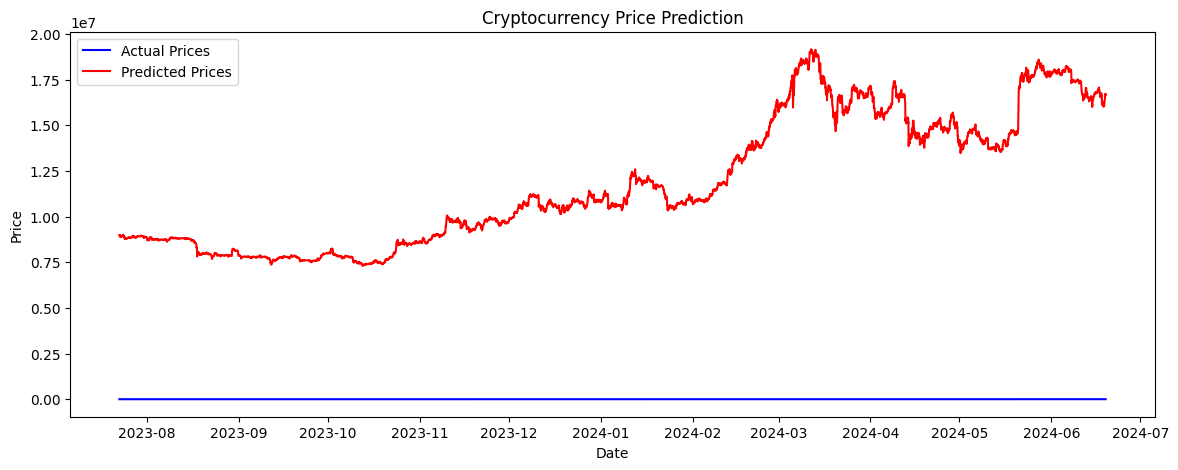

In [22]:
# Plot the results
plt.figure(figsize=(14,5))
plt.plot(data.index[-len(y_test):], y_test, color='blue', label='Actual Prices')
plt.plot(data.index[-len(y_test):], predictions, color='red', label='Predicted Prices')
plt.title('Cryptocurrency Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## **BACKTEST THE MODEL:**

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [54]:
# Load the historical data
data_path = 'data.csv'
data = pd.read_csv(data_path, parse_dates=['date'])
data

,date,open,high,low,close,volume
0,2019-11-27 07:00:00,146.00,146.00,146.00,146.00,0.010
1,2019-11-27 08:00:00,125.03,145.01,125.03,133.00,0.080
2,2019-11-27 09:00:00,133.00,133.00,133.00,133.00,0.000
3,2019-11-27 10:00:00,142.20,144.52,142.10,142.62,2832.710
4,2019-11-27 11:00:00,142.70,146.92,142.22,146.58,9079.800
...,...,...,...,...,...,...
39981,2024-06-19 04:00:00,3564.22,3585.00,3557.31,3559.34,107544.005
39982,2024-06-19 05:00:00,3559.35,3566.78,3547.22,3548.79,89662.782
39983,2024-06-19 06:00:00,3548.80,3561.58,3547.53,3560.00,40846.363
39984,2024-06-19 07:00:00,3560.00,3565.00,3531.52,3543.07,142649.571


In [55]:
# Preprocess the data
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data = data[['open', 'high', 'low', 'close', 'volume']]

In [56]:
# Add a dummy feature to match the expected input shape
data['dummy_feature'] = data['close'].shift(1).fillna(method='bfill')  # Use a lagged close as a dummy feature

In [57]:
# Define the feature columns and target column
feature_cols = ['open', 'high', 'low', 'close', 'volume', 'dummy_feature']
target_col = 'close'

In [58]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [59]:
# Define the sequence length
sequence_length = 60

# Create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y = data[i + sequence_length, 3]  # close price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(scaled_data, sequence_length)

In [60]:
# Load the saved model
model_path = 'lstm_model.h5'
model = load_model(model_path)

In [61]:
# Generate predictions
y_pred = model.predict(X)

1248/1248 [==============================] - 24s 18ms/step


In [62]:
# Invert the scaling for actual and predicted values
y_pred_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], scaled_data.shape[1] - 1)), y_pred.reshape(-1, 1))))
y_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y.shape[0], scaled_data.shape[1] - 1)), y.reshape(-1, 1))))

In [63]:
# Simulation parameters
initial_capital = 500  # Initial capital in USD
capital = initial_capital
num_shares = 0
portfolio_values = []

In [64]:
# Simulate trading
for i in range(len(y_pred_rescaled) - 1):
    current_price = y_rescaled[i, -1]
    next_predicted_price = y_pred_rescaled[i + 1, -1]

    # Buy signal
    if next_predicted_price > current_price:
        num_shares = capital // current_price  # Buy as many shares as possible
        capital -= num_shares * current_price  # Update capital after buying shares

    # Sell signal
    elif next_predicted_price < current_price and num_shares > 0:
        capital += num_shares * current_price  # Sell all shares
        num_shares = 0

    # Calculate portfolio value
    portfolio_value = capital + num_shares * current_price
    portfolio_values.append(portfolio_value)

# Final portfolio value
final_portfolio_value = portfolio_values[-1]

In [65]:
# Performance metrics
total_profit = final_portfolio_value - initial_capital
return_percentage = (total_profit / initial_capital) * 100

print(f'Initial Capital: ${initial_capital}')
print(f'Final Portfolio Value: ${final_portfolio_value:.2f}')
print(f'Total Profit: ${total_profit:.2f}')
print(f'Return Percentage: {return_percentage:.2f}%')

Initial Capital: $500
Final Portfolio Value: $37.73
Total Profit: $-462.27
Return Percentage: -92.45%


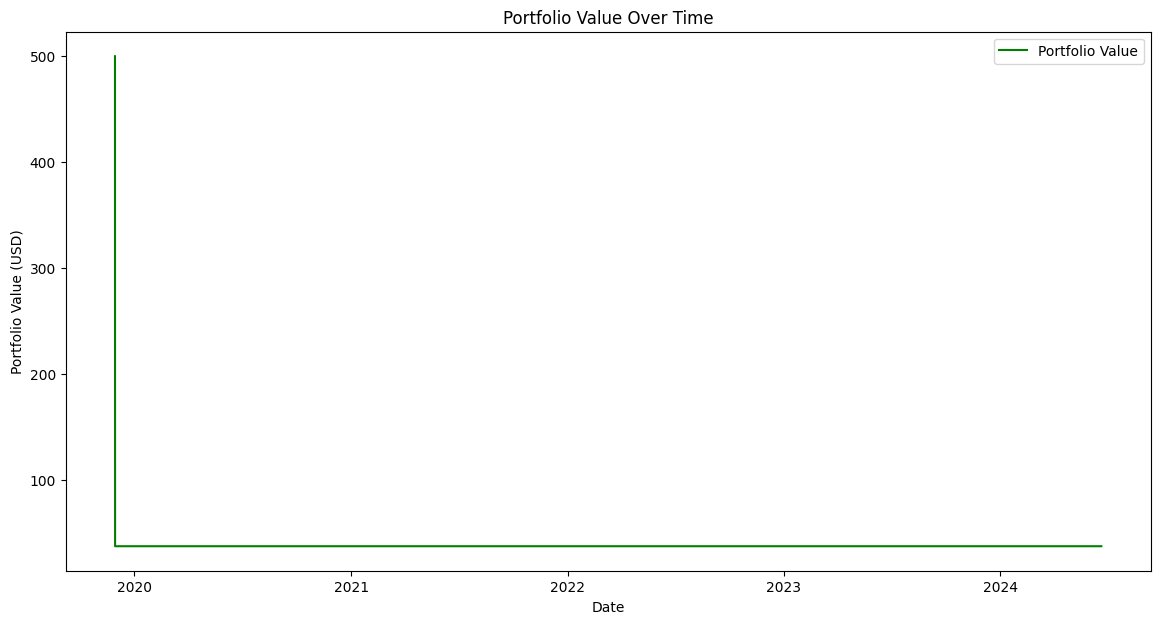

In [66]:
# Plot the portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(data.index[sequence_length:-1], portfolio_values, color='green', label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.show()